# 目的
- 正味重量の推定を行い、傾向変化の有無を捉える


In [1]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

import ChocoUtils as cu

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 対象データの抽出
- taste : ピーナッツ味
- 期間 : 全期間（賞味期限でグループ分けするため、賞味期限の記録が無いものは除外）

In [2]:
dbfile = '../../data/choco-ball.db'
data = cu.get_data(db_file=dbfile, filter_str='best_before is not NULL and taste == 0')
data = data.drop(columns=['shop', 'factory'])
data.best_before = pd.to_datetime(data.best_before)
data.measure_date = pd.to_datetime(data.measure_date)
data.head()

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE best_before is not NULL and taste == 0;
Shape of MeasurementData(record_num, n_columns) : (479, 14)


,measure_date,best_before,prd_number,weight,box_weight,ball_number,angel,campaign,taste,buyer,net_weight,mean_weight
0,2017-11-21,2018-06-01,None,34.000,4.815,18,0,1,0,時田,29.185,1.621389
1,2017-11-22,2018-06-01,None,34.193,4.818,17,0,1,0,時田,29.375,1.727941
2,2017-11-23,2018-06-01,None,35.344,4.836,16,0,1,0,時田,30.508,1.906750
3,2017-11-23,2018-06-01,None,34.031,4.836,18,0,1,0,時田,29.195,1.621944
4,2017-11-23,2018-06-01,None,34.198,4.834,18,0,1,0,時田,29.364,1.631333


In [3]:
data.groupby(['taste']).count()

,measure_date,best_before,prd_number,weight,box_weight,ball_number,angel,campaign,buyer,net_weight,mean_weight
taste,,,,,,,,,,,
0,479,479,449,479,479,479,479,479,479,479,479


# データの可視化
- まずはデータを眺める

In [4]:
data['bb_ym'] = [x.strftime('%Y/%m') for x in data.best_before]
data.head()

,measure_date,best_before,prd_number,weight,box_weight,ball_number,angel,campaign,taste,buyer,net_weight,mean_weight,bb_ym
0,2017-11-21,2018-06-01,None,34.000,4.815,18,0,1,0,時田,29.185,1.621389,2018/06
1,2017-11-22,2018-06-01,None,34.193,4.818,17,0,1,0,時田,29.375,1.727941,2018/06
2,2017-11-23,2018-06-01,None,35.344,4.836,16,0,1,0,時田,30.508,1.906750,2018/06
3,2017-11-23,2018-06-01,None,34.031,4.836,18,0,1,0,時田,29.195,1.621944,2018/06
4,2017-11-23,2018-06-01,None,34.198,4.834,18,0,1,0,時田,29.364,1.631333,2018/06


In [5]:
# たぶんハズレ値の除外
data = data[-data['best_before'].isin(['2018-02-01'])]

In [6]:
date_list = list(set(data.bb_ym))
date_list.sort()

## 賞味期限月毎のデータ件数

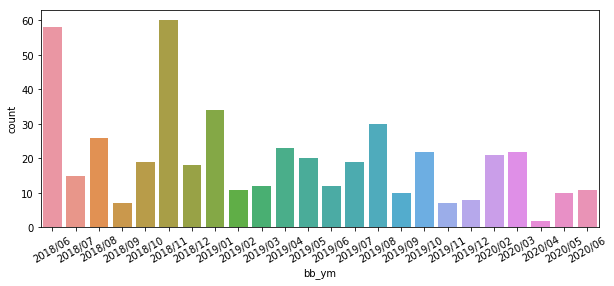

In [7]:
# data.groupby(pd.Grouper(key='best_before', freq='M')).count()

fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

sns.countplot(x='bb_ym', data=data, order=date_list, ax=ax)
ret = ax.set_xticklabels(date_list, rotation=30)

## 正味重量の分布
- こうしてみると、賞味期限が2020年の商品から正味重量の傾向が下がったように見える
- 重要なことは、表記上の重量（28g）を下回るものは一つも無いということ

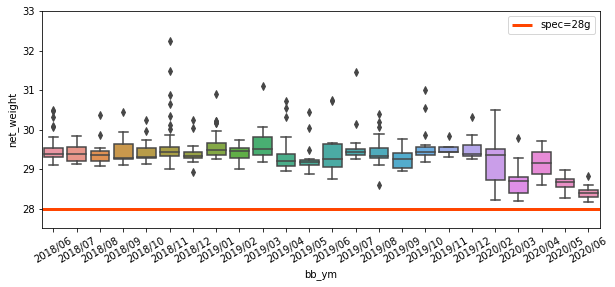

In [8]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

ax = sns.boxplot(x="bb_ym", y="net_weight", data=data, 
                 order=date_list, ax=ax)
ax.set_ylim(27.5, 33)
xmin, xmax, _, _ = ax.axis()
ax.hlines(28, xmin, xmax, color='#ff4500', lw=3, label='spec=28g')
ax.legend()
ret = ax.set_xticklabels(date_list, rotation=30)

## 箱重量の分布
- 箱の重量自体はあまり変化無いとみて良いと思う
- 重量の幅が0.3g程度なので

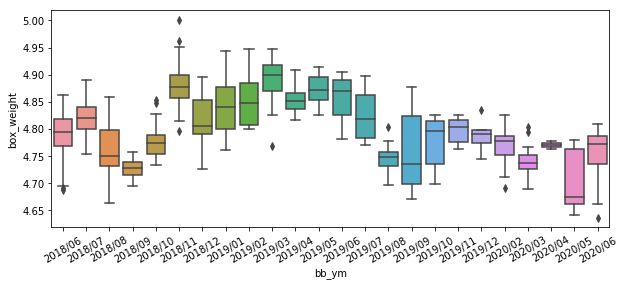

In [9]:
date_list = list(set(data.bb_ym))
date_list.sort()

fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

ax = sns.boxplot(x="bb_ym", y="box_weight", data=data, 
                 order=date_list, ax=ax)
ret = ax.set_xticklabels(date_list, rotation=30)

## 重量のヒストグラム

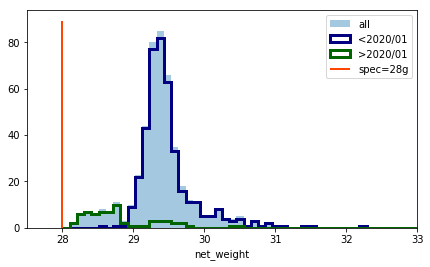

In [10]:
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1, 1)
ax.set_xlim(27.5, 33)
bins = np.linspace(28, 33, 50)

sns.distplot(data.net_weight, bins=bins, norm_hist=False, kde=None, ax=ax, label='all')
_, _, ymin, ymax = ax.axis()
ax.vlines(28, ymin, ymax, color='#ff4500', lw=2, label='spec=28g')

data_a = data[data.best_before.dt.date < datetime.date(2020, 1, 1)]
sns.distplot(data_a.net_weight, bins=bins, norm_hist=False, kde=None, 
             hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "#000080"}, 
             ax=ax, label='<2020/01')

data_b = data[data.best_before.dt.date >= datetime.date(2020, 1, 1)]
sns.distplot(data_b.net_weight, bins=bins, norm_hist=False, kde=None, 
             hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "#006400"}, 
             ax=ax, label='>2020/01')

ax.legend()

# 平均値の推定
簡単のために、2つの期間にデータを分けて、それぞれの期間の平均値を推定する。


## モデル
- 重量yは正規分布$\mathcal{N}(y_n | \mu, \tau)$に従うとする観測値。
- $\mu$は平均のパラメータで、正規分布$\mathcal{N}(\mu | \mu_m, \tau_m)$に従うとする
- $\tau$は精度のパラメータで、ガンマ分布$\mathrm{Gam}(\tau | a, b)$に従うとする

### ガンマ分布の確認
精度パラメータの分布。事前分布は無情報とするのので広めの分布にする。

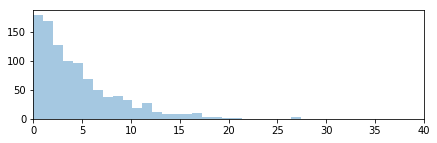

In [11]:
fig = plt.figure(figsize=(7, 2))
ax = fig.subplots(1, 1)
ax.set_xlim(0, 40)

shape, scale = 1., 5.
s = np.random.gamma(shape, scale, 1000)
sns.distplot(s, kde=False, ax=ax)

In [12]:
idx = [1 if f else 0 for f in list(data.best_before.dt.date >= datetime.date(2020, 1, 1))]
spec = 28.
tau_m = 0.1
a, b = 1., 5.

with pm.Model() as model:
    mus = pm.Normal('mu', mu=spec, tau=tau_m, shape=2)
    taus = pm.Gamma('tau', alpha=a, beta=b, shape=2)
    weights = pm.Normal('weights', mu=mus[idx], tau=taus[idx], observed=data.net_weight.values)
    #nus = pm.Exponential('nu', 1/10, shape=2)
    #weights = pm.StudentT('weights', nu=nus[idx], mu=mus[idx], lam=taus[idx], observed=data.net_weight.values)

with model:
    trace = pm.sample(5000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:07<00:00, 3132.97draws/s]


/home/yoichi/workspace/choco-ball-statistics/env_choco/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdaacadbbe0>,
      dtype=object)

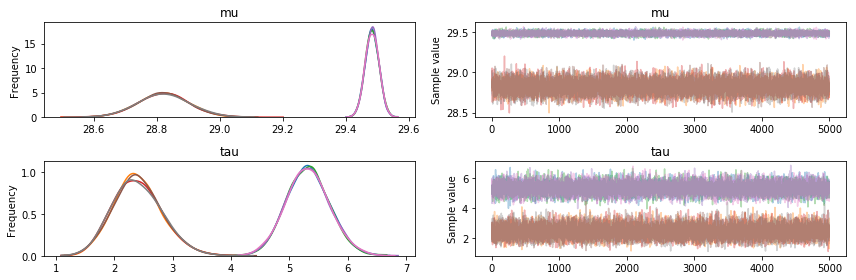

In [13]:
pm.traceplot(trace)

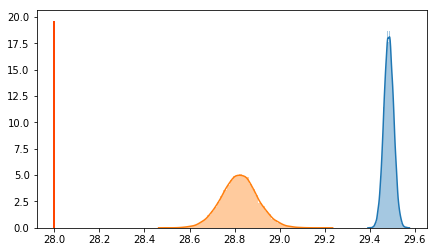

In [14]:
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1, 1)

mu_trace = trace['mu']
sns.distplot(mu_trace[:,0], ax=ax, label='<2020/01')
sns.distplot(mu_trace[:,1], ax=ax, label='>=2020/01')

_, _, ymin, ymax = ax.axis()
ax.vlines(28, ymin, ymax, color='#ff4500', lw=2, label='spec=28g')

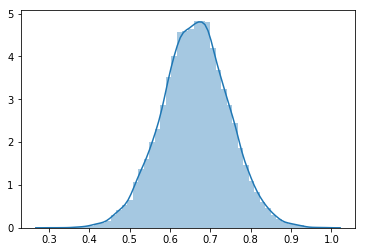

In [15]:
sns.distplot((mu_trace[:,0]-mu_trace[:,1]))